In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# statsmodels API 불러오기
import statsmodels.api as sm

from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
from tqdm import tqdm

In [2]:
# 설정값
IMP_CUM_THRESH = 0.90  # 누적 상대 중요도 컷오프
VIF_THRESH     = 10    # VIF 컷오프
N_SPLITS       = 5     # CV fold 수

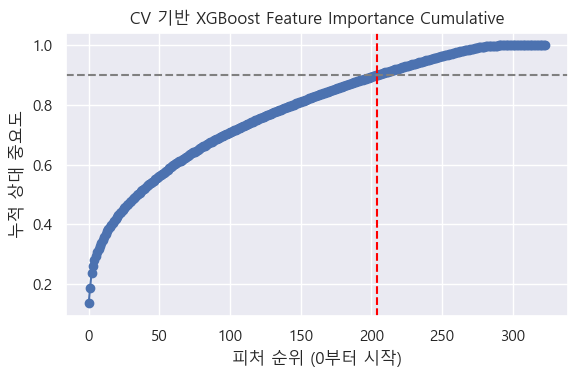

In [3]:
# 데이터 로드 및 전처리
df        = pd.read_csv("merged_2018_train.csv")
X         = df.drop(columns=['ID','Segment'])
y         = df['Segment']
le        = LabelEncoder()
y_enc     = le.fit_transform(y)
num_feats = X.select_dtypes(include=np.number).columns.tolist()
X_num     = X[num_feats]

# 전체 TRAIN 스케일링
scaler    = StandardScaler().fit(X_num)
X_scaled  = pd.DataFrame(scaler.transform(X_num), columns=num_feats)

# CV 기반 XGBoost 중요도 평균
skf     = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
imp_mat = np.zeros((N_SPLITS, len(num_feats)))
for fold, (tr, va) in enumerate(skf.split(X_scaled, y_enc)):
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_scaled.iloc[tr], y_enc[tr])
    imp_mat[fold, :] = model.feature_importances_

mean_imp = imp_mat.mean(axis=0)
df_imp   = (
    pd.DataFrame({'feature': num_feats, 'importance': mean_imp})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)
df_imp['rel_imp']     = df_imp['importance'] / df_imp['importance'].sum()
df_imp['cum_rel_imp'] = df_imp['rel_imp'].cumsum()

# 누적 상대 중요도 그래프 
n_keep = (df_imp['cum_rel_imp'] <= IMP_CUM_THRESH).sum() + 1
x_pos  = n_keep - 1  # zero-based
plt.figure(figsize=(6,4))
plt.plot(df_imp['cum_rel_imp'].values, marker='o')
plt.axhline(IMP_CUM_THRESH, color='gray', linestyle='--')
plt.axvline(x=x_pos, color='red', linestyle='--')
plt.title("CV 기반 XGBoost Feature Importance Cumulative")
plt.xlabel("피처 순위 (0부터 시작)")
plt.ylabel("누적 상대 중요도")
plt.tight_layout()
plt.show()

# 누적 90%까지의 피처 선택
top_feats = df_imp.loc[:n_keep-1, 'feature'].tolist()

In [4]:
# VIF 제거 (진행률 표시)
X_vif = X_scaled[top_feats].replace([np.inf, -np.inf], np.nan).fillna(
    X_scaled[top_feats].median()
)
Xc     = sm.add_constant(X_vif)
total  = Xc.shape[1] - 1  # 상수항 제외 피처 수

vif_vals = []
for i in tqdm(range(1, Xc.shape[1]),
              desc="VIF 처리",
              ncols=70,
              bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{percentage:3.0f}%]'):
    vif_vals.append(variance_inflation_factor(Xc.values, i))

vif_df = (
    pd.DataFrame({'feature': Xc.columns[1:], 'vif': vif_vals})
      .sort_values('vif', ascending=False)
      .reset_index(drop=True)
)
keep_feats = vif_df.loc[vif_df['vif'] <= VIF_THRESH, 'feature'].tolist()

VIF 처리: 100%|████████████████████████████████████████ 205/205 [100%]


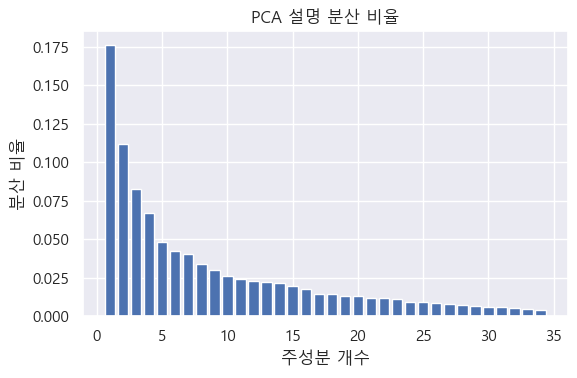

최종 선택 피처 개수: 119
피처 목록: ['컨택건수_이용유도_EM_B0M', '이용여부_3M_해외겸용_본인', '선결제건수_R3M', '증감율_이용금액_체크_분기', '증감율_이용건수_체크_분기', '잔액_일시불_B2M', '소지여부_신용', '연체건수_R6M', '당사멤버쉽_방문횟수_R6M', '연체건수_R3M', '포인트_적립포인트_R3M', '한도증액금액_R12M', '월상환론한도금액', '포인트_이용포인트_R12M', '방문일수_앱_R6M', '변동률_카드론평잔', '당사멤버쉽_방문횟수_B0M', '컨택건수_이용유도_LMS_R6M', '월상환론상향가능한도금액', '포인트_포인트_월적립_R3M', '컨택건수_이용유도_LMS_B0M', '증감율_이용건수_신용_분기', '홈페이지_선결제건수_R6M', '상담건수_B0M', '포인트_포인트_월적립_B0M', '회원여부_이용가능', '_1순위카드이용건수', '수신거부여부_TM', '컨택건수_이용유도_청구서_B0M', '컨택건수_채권_R6M', '컨택건수_카드론_TM_R6M', '컨택건수_이용유도_청구서_R6M', '인입일수_IB_B0M', 'RV최소결제비율', '강제한도감액횟수_R12M', '연체원금_B1M', '상담건수_R6M', 'CL이자율_할인전', '회원여부_이용가능_CA', '탈회횟수_발급1년이내', '탈회횟수_발급6개월이내', '연체원금_최근', '컨택건수_채권_B0M', '포인트_적립포인트_R12M', '한도증액후경과월', '홈페이지_금융건수_R3M', '강제한도감액금액_R12M', '변동률_CA평잔', '컨택건수_카드론_TM_B0M', '당사멤버쉽_방문월수_R6M', '자발한도감액금액_R12M', '자발한도감액후경과월', '일시상환론한도금액', '수신거부여부_SMS', '연체감액여부_R3M', '변동률_잔액_B1M', '변동률_잔액_일시불_B1M', '강제한도감액후경과월', '할인건수_R3M', '잔액_할부_유이자_B0M', '컨택건수_CA_청구서_R6M', '컨택건수_카드론_LMS_R6M', 

In [5]:
# PCA 적용 (제거된 피처만)
drop_feats = [f for f in top_feats if f not in keep_feats]
if drop_feats:
    pca = PCA(n_components=0.95, random_state=42)
    pcs = pca.fit_transform(X_vif[drop_feats])
    pc_cols = [f"PC{i+1}" for i in range(pcs.shape[1])]
    df_pcs  = pd.DataFrame(pcs, columns=pc_cols, index=X_vif.index)
    X_final = pd.concat([X_vif[keep_feats], df_pcs], axis=1)

    # PCA 설명 분산 비율 그래프
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
            pca.explained_variance_ratio_)
    plt.title("PCA 설명 분산 비율")
    plt.xlabel("주성분 개수")
    plt.ylabel("분산 비율")
    plt.tight_layout()
    plt.show()
else:
    X_final = X_vif[keep_feats].copy()

# 최종 피처 정보 출력
print("최종 선택 피처 개수:", X_final.shape[1])
print("피처 목록:", list(X_final.columns))

In [6]:
# 누적 90%까지의 피처 선택
top_feats = df_imp.loc[:n_keep-1, 'feature'].tolist()

# 선택된 피처 개수 및 목록 출력
print(f"누적 90%까지 선택된 피처 수: {len(top_feats)}")
print("선택된 피처 목록:")
for feat in top_feats:
    print(f" - {feat}")

누적 90%까지 선택된 피처 수: 205
선택된 피처 목록:
 - 이용금액_R3M_신용체크
 - 청구금액_R3M
 - 평잔_CA_6M
 - 청구금액_R6M
 - 입회일자_신용
 - OS_missing_flag
 - 불만제기후경과월_R12M
 - _1순위카드이용금액
 - 소지카드수_유효_신용
 - 변동률_RVCA평잔
 - 이용금액_R3M_체크
 - 월상환론한도금액
 - 카드이용한도금액_B2M
 - 수신거부여부_메일
 - RV전환가능여부_N
 - 강제한도감액금액_R12M
 - 일시상환론한도금액
 - 카드이용한도금액_B1M
 - 강제한도감액횟수_R12M
 - 이용가능카드수_신용
 - 소지카드수_이용가능_신용
 - 유효카드수_신용체크
 - CA이자율_할인전
 - 입회경과개월수_신용
 - 연체감액여부_R3M
 - 잔액_현금서비스_B0M
 - 수신거부여부_TM
 - 평잔_CA_3M
 - _2순위카드이용금액
 - 최종카드발급경과월
 - 카드이용한도금액
 - 선결제건수_R6M
 - 한도증액횟수_R12M
 - 잔액_현금서비스_B2M
 - 마일_적립포인트_R12M
 - 할인금액_청구서_R3M
 - 마일_적립포인트_R3M
 - 평잔_카드론_6M
 - RV_평균잔액_R3M
 - 이용카드수_체크
 - 월중평잔_카드론
 - 평잔_카드론_3M
 - 잔액_카드론_B2M
 - 한도증액후경과월
 - 회원여부_이용가능_CA
 - 컨택건수_이용유도_EM_R6M
 - 수신거부여부_SMS
 - 증감율_이용금액_신판_분기
 - 동의여부_한도증액안내
 - 잔액_카드론_B0M
 - 캠페인접촉건수_R12M_num
 - 마케팅동의여부
 - 일시불ONLY전환가능여부
 - 이용카드수_신용체크
 - 평잔_6M
 - 선결제건수_R3M
 - 강제한도감액후경과월
 - 할인금액_청구서_B0M
 - 컨택건수_이용유도_EM_B0M
 - 인입일수_ARS_B0M
 - 월중평잔_CA_B0M
 - _2순위카드이용건수
 - 한도증액금액_R12M
 - RV_평균잔액_R6M
 - RV_최대잔액_R6M
 - 유효카드수_신용
 - 이용가능

In [7]:
# 원본 df에 ID/Segment 추가 후 저장 예시
final_df = pd.concat([df[['ID','Segment']].reset_index(drop=True), X_final.reset_index(drop=True)], axis=1)
final_df.to_csv("final_features.csv", index=False)
final_df

,ID,Segment,컨택건수_이용유도_EM_B0M,이용여부_3M_해외겸용_본인,선결제건수_R3M,증감율_이용금액_체크_분기,증감율_이용건수_체크_분기,잔액_일시불_B2M,소지여부_신용,연체건수_R6M,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
0,TRAIN_000000,D,2.852152,-1.220107,-0.275321,0.094816,0.099563,-0.395686,0.168081,-0.345799,...,0.072744,-1.888965,-0.437461,-0.362528,1.605004,1.702083,0.162297,1.838191,-0.435286,0.046616
1,TRAIN_000001,E,-0.460104,-1.220107,-0.275321,0.094816,0.099563,-0.086107,0.168081,-0.345799,...,-0.454872,0.870847,-0.772677,-0.972391,-0.300709,-0.609051,0.156641,0.005973,-0.109270,0.028481
2,TRAIN_000002,C,-0.205315,-1.220107,-0.275321,0.094816,0.099563,0.108172,0.168081,-0.345799,...,-0.380985,-2.328726,-0.464690,-0.123804,-0.247201,-0.033638,-0.897781,-0.016793,-1.030393,0.053991
3,TRAIN_000003,D,0.049474,0.819600,-0.275321,0.094816,0.099563,-0.334404,0.168081,-0.345799,...,-1.388565,-1.128249,1.025694,-0.520446,-0.187874,0.830027,0.266552,0.241093,-0.736439,-0.335645
4,TRAIN_000004,E,-0.460104,0.819600,-0.275321,-0.391333,-0.766354,-0.468854,0.168081,-0.345799,...,-1.907164,2.622725,-0.540202,-0.919813,-0.510716,0.016389,0.239240,-0.290470,-0.967699,1.889787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,TRAIN_399995,E,-0.460104,0.819600,-0.275321,-0.074392,-0.275926,-0.468854,0.168081,-0.345799,...,0.226014,0.837743,0.868829,0.173433,-0.545565,0.008325,-0.136489,-0.279707,-0.664071,1.180973
399996,TRAIN_399996,D,2.852152,0.819600,-0.275321,0.094816,0.099563,0.107248,0.168081,-0.345799,...,-0.691914,0.807116,-0.239357,1.208707,1.174363,0.233371,1.019874,0.389598,0.279936,0.013978
399997,TRAIN_399997,C,-0.460104,0.819600,-0.275321,0.094816,0.099563,-0.086107,0.168081,-0.345799,...,0.858392,-0.399270,-0.300778,0.181367,0.095234,-1.124464,0.984302,0.787980,0.664404,0.081570
399998,TRAIN_399998,E,-0.460104,-1.220107,-0.275321,0.094816,0.099563,-0.468854,0.168081,-0.345799,...,-0.008557,0.854436,0.582489,-0.379367,0.027314,0.571864,0.379142,0.194363,-0.386817,0.222013


In [8]:
# TEST 데이터 로드 및 숫자형 피처만 추출
test_df    = pd.read_csv("merged_2018_test.csv")
X_test_num = test_df.drop(columns=['ID','Segment'], errors='ignore')[num_feats]

# 스케일링
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=num_feats,
    index=X_test_num.index
)

# 누적 상대 중요도→VIF 통과 피처만 추출
X_test_vif  = X_test_scaled[top_feats]
X_test_keep = X_test_vif[keep_feats]
drop_feats  = [f for f in top_feats if f not in keep_feats]

# PCA 적용
if drop_feats:
    pcs_test    = pca.transform(X_test_vif[drop_feats])
    df_pcs_test = pd.DataFrame(pcs_test, columns=pc_cols, index=X_test_vif.index)
    X_test_final = pd.concat([X_test_keep, df_pcs_test], axis=1)
else:
    X_test_final = X_test_keep.copy()

# ID·Segment(sample_submission) 결합 및 저장
sample_sub     = pd.read_csv("sample_submission.csv")
final_test_df  = pd.concat([
    sample_sub[['ID','Segment']].reset_index(drop=True),
    X_test_final.reset_index(drop=True)
], axis=1)
final_test_df.to_csv("final_test_features_with_segment.csv", index=False, encoding="utf-8-sig")
final_test_df

,ID,Segment,컨택건수_이용유도_EM_B0M,이용여부_3M_해외겸용_본인,선결제건수_R3M,증감율_이용금액_체크_분기,증감율_이용건수_체크_분기,잔액_일시불_B2M,소지여부_신용,연체건수_R6M,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
0,TEST_00000,A,-0.205315,0.819600,-0.275321,0.094816,0.099563,-0.163370,0.168081,-0.345799,...,0.360496,0.080540,0.048570,-0.339397,0.668019,-0.311102,0.603158,0.411611,0.745618,-0.417759
1,TEST_00001,A,0.049474,0.819600,-0.275321,-0.756880,-0.344323,-0.328857,0.168081,-0.345799,...,0.820847,-1.369032,0.262549,-0.510418,-2.038775,-0.644208,1.243926,-0.893193,0.554468,1.122949
2,TEST_00002,A,0.049474,-1.220107,-0.275321,0.094816,0.099563,0.000665,0.168081,-0.345799,...,0.341343,0.774613,-0.007612,2.374805,-0.373258,-0.434787,0.441377,-0.571405,0.231196,-0.126261
3,TEST_00003,A,-0.205315,0.819600,-0.275321,0.094816,0.099563,-0.319216,0.168081,3.057236,...,1.120589,-0.741801,0.067876,-0.499171,-0.558278,-0.507193,0.514286,0.041840,-0.255028,-0.030531
4,TEST_00004,A,-0.460104,0.819600,-0.275321,-0.342084,-0.269204,-0.397139,0.168081,-0.345799,...,0.407260,0.645069,-1.601049,-0.292943,0.740784,0.210184,0.078369,-0.615937,-0.664621,2.080166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,TEST_99995,A,-0.460104,-1.220107,-0.275321,0.094816,0.099563,-0.468854,-5.949515,-0.345799,...,0.767710,0.394552,-0.354645,0.283543,0.161704,-1.470385,0.418974,0.051307,-0.127643,-0.281636
99996,TEST_99996,A,0.049474,-1.220107,2.830256,0.094816,0.099563,-0.437421,0.168081,-0.345799,...,-0.044202,-0.759843,0.115137,-0.639020,-0.711441,-0.297865,-0.963083,-0.516213,1.343004,0.082172
99997,TEST_99997,A,-0.205315,-1.220107,-0.275321,0.094816,0.099563,-0.468854,0.168081,-0.345799,...,0.204810,-0.312855,0.386862,-0.263582,-0.038685,1.521084,-0.649638,-0.229434,0.255854,-0.063987
99998,TEST_99998,A,-0.460104,0.819600,4.383044,-0.072038,0.147917,1.457561,0.168081,-0.345799,...,5.436492,4.936905,0.952639,-1.306003,-3.844825,-0.452792,-1.172972,0.320290,1.716371,-1.273867
